# BASE

#### IMPORT

In [184]:
import pandas as pd
from matplotlib import pyplot as plt, dates as mdates, ticker as ticker
from matplotlib.widgets import CheckButtons
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import datetime

#### FUNCTIONS

In [2]:
def cols_to_numeric(*args):
    result = []
    for arg in args:
        arg = pd.to_numeric(arg, errors='coerce')
        result.append(arg)
    return result
 

def create_periods(df):
    result = [None] * 5
    result[0] = df.iloc[len(df.index)-(24*1):]
    result[1] = df.iloc[len(df.index)-(24*2):]
    result[2] = df.iloc[len(df.index)-(24*3):]
    result[3] = df.iloc[len(df.index)-(24*7):]
    result[4] = df.iloc[len(df.index)-(24*14):]
    result[0].reset_index(inplace = True, drop = True)
    result[1].reset_index(inplace = True, drop = True)
    result[2].reset_index(inplace = True, drop = True)
    result[3].reset_index(inplace = True, drop = True)
    result[4].reset_index(inplace = True, drop = True)
    return result

In [3]:
%matplotlib widget
def draw_line_graph(df, title, ex_tick='month'):
    colors = ['silver','darkgreen','red','deepskyblue', 'gold', 'blueviolet', 'mediumorchid', 'lawngreen', 'aqua',
             'purple', 'blue', 'darkgoldenrod', 'darkorange', 'magenta', 'forestgreen', 'midnightblue']
    lines = []
    check_labels = []
    check_states = []
    
    fig, ax = plt.subplots(figsize=(17,10));
    for column, clr in zip(df, colors):
        if column != 'Date':
            l, = ax.plot(df['Date'], df[column], color=clr, alpha=0.5, linewidth=2)
            lines.append(l)
            check_states.append(l.get_visible())
            check_labels.append(column.rsplit('[', 1)[0])
    
    #plot apperance
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha='left');
    plt.subplots_adjust(left=0.23)
    ax.set_title(title);
    ax.grid();
    ax.set_ylabel(('[' + column.rsplit('[', 1)[1]),fontsize = 16);
    ax.yaxis.set_major_locator(ticker.MultipleLocator(25));
    ax.set_xlabel('', fontsize = 16);
    if ex_tick == 'day':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1));
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a-%d-%m-%y'));
    elif ex_tick == 'hour':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval = 3));
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1));
    
    
    #checkboxes
    ax_checkbox = plt.axes([0.03, 0.6, 0.17, 0.3])
    checkboxes = CheckButtons(ax_checkbox, check_labels, check_states)
    [rec.set_facecolor(colors[i+1]) for i, rec in enumerate(checkboxes.rectangles)]
    def callback(label):
        index = check_labels.index(label)
        lines[index].set_visible(not lines[index].get_visible())
        plt.draw()
    checkboxes.on_clicked(callback)
    
    return checkboxes

In [4]:
def df_corr_3days(original_df, day = 0):
    df = pd.DataFrame(index=range(0, 24))
    for column in original_df:
        if column != 'Date':
            Bufor = original_df[column].iloc[len(price_all.index)-(24*(day+1)):].copy()
            Bufor.reset_index(inplace = True, drop = True)
            df = df.join(Bufor);
            df.rename(columns = {column : column.rsplit('[', 1)[0]+' tomorrow'}, inplace = True)
            Bufor = original_df[column].iloc[len(price_all.index)-(24*(day+2)):len(price_all.index)-(24*(day+1))].copy()
            Bufor.reset_index(inplace = True, drop = True)
            df = df.join(Bufor);
            df.rename(columns = {column : column.rsplit('[', 1)[0]+' today'}, inplace = True)
            Bufor = original_df[column].iloc[len(price_all.index)-(24*(day+3)):len(price_all.index)-(24*(day+2))].copy()
            Bufor.reset_index(inplace = True, drop = True)
            df = df.join(Bufor);
            df.rename(columns = {column : column.rsplit('[', 1)[0]+' yesterday'}, inplace = True)
    
    return df

# DATA MANAGEMENT

#### LOAD DATA

In [5]:
price_og       = pd.read_csv('price_1.csv',       sep=';')
generation_og  = pd.read_csv('generation_1.csv',  sep=';')
consumption_og = pd.read_csv('consumption_1.csv', sep=';')
#consumption_og
#consumption_og.dtypes

#### WORK COPY

In [6]:
price_all  = price_og.copy()
gener_all  = generation_og.copy()
consu_all = consumption_og.copy()

#Consolidate date columns
price_all['Date'] = price_all['Date'] + ' ' + price_all['Time of day']
price_all['Date'] = pd.to_datetime(price_all['Date'], errors='coerce')
gener_all['Date'] = gener_all['Date'] + ' ' + gener_all['Time of day']
gener_all['Date'] = pd.to_datetime(gener_all['Date'], errors='coerce')
consu_all['Date'] = consu_all['Date'] + ' ' + consu_all['Time of day']
consu_all['Date'] = pd.to_datetime(consu_all['Date'], errors='coerce')

#delete redundant column
price_all.drop(labels = 'Time of day', axis  = 1, inplace=True);
gener_all.drop(labels = 'Time of day', axis  = 1, inplace=True);
consu_all.drop(labels = 'Time of day', axis  = 1, inplace=True);

price_all.drop(labels = 'Germany/Austria/Luxembourg[€/MWh]', axis  = 1, inplace=True);
#gener_all.drop(labels = 'Germany/Austria/Luxembourg[€/MWh]', axis  = 1, inplace=True);
#consu_all.drop(labels = 'Germany/Austria/Luxembourg[€/MWh]', axis  = 1, inplace=True);


price_all = price_all.replace(',','.', regex=True)
gener_all = gener_all.replace(',','.', regex=True)
consu_all = consu_all.replace(',','.', regex=True)

#### ADJUSTING DATA

In [7]:
price_all['Denmark 1[€/MWh]']
price_all['Denmark 2[€/MWh]']
price_all['Northern Italy[€/MWh]']
price_all['Poland[€/MWh]']
price_all['Czech Republic[€/MWh]']
price_all['Hungary[€/MWh]']

[price_all['Denmark 1[€/MWh]'],
 price_all['Denmark 2[€/MWh]'],
 price_all['Northern Italy[€/MWh]'],
 price_all['Poland[€/MWh]'],
 price_all['Czech Republic[€/MWh]'],
 price_all['Hungary[€/MWh]']] = cols_to_numeric(price_all['Denmark 1[€/MWh]'],
                                                price_all['Denmark 2[€/MWh]'],
                                                price_all['Northern Italy[€/MWh]'],
                                                price_all['Poland[€/MWh]'],
                                                price_all['Czech Republic[€/MWh]'],
                                                price_all['Hungary[€/MWh]'])

[gener_all['Biomass[MWh]'],
 gener_all['Wind offshore[MWh]'],
 gener_all['Wind onshore[MWh]'],
 gener_all['Photovoltaics[MWh]'],
 gener_all['Nuclear[MWh]'],
 gener_all['Lignite[MWh]'],
 gener_all['Hard coal[MWh]'],
 gener_all['Fossil gas[MWh]'],
 gener_all['Hydro pumped storage[MWh]']] = cols_to_numeric(gener_all['Biomass[MWh]'],
                                                           gener_all['Wind offshore[MWh]'],
                                                           gener_all['Wind onshore[MWh]'],
                                                           gener_all['Photovoltaics[MWh]'],
                                                           gener_all['Nuclear[MWh]'],
                                                           gener_all['Lignite[MWh]'],
                                                           gener_all['Hard coal[MWh]'],
                                                           gener_all['Fossil gas[MWh]'],
                                                           gener_all['Hydro pumped storage[MWh]'])

[consu_all['Hydro pumped storage[MWh]'],
 consu_all['Residual load[MWh]'],
 consu_all['Total (grid load)[MWh]']] = cols_to_numeric(consu_all['Hydro pumped storage[MWh]'],
                                                        consu_all['Residual load[MWh]'],
                                                        consu_all['Total (grid load)[MWh]'])

price_all.replace(0, np.nan, inplace=True)
gener_all.replace(0, np.nan, inplace=True)
consu_all.replace(0, np.nan, inplace=True)

[price_days_1, price_days_2, price_days_3, price_week_1, price_week_2] = create_periods(price_all)
[gener_days_1, gener_days_2, gener_days_3, gener_week_1, gener_week_2] = create_periods(gener_all)
[consu_days_1, consu_days_2, consu_days_3, consu_week_1, consu_week_2] = create_periods(consu_all)

# BASIC STATISTICS

#### PRICES

In [8]:
price_all.describe()

Germany/Luxembourg[€/MWh]  Denmark 1[€/MWh]  Denmark 2[€/MWh]  \
count               21206.000000      21179.000000      21187.000000   
mean                   52.583889         47.978991         49.553581   
std                    44.726743         41.164451         41.518938   
min                   -83.940000        -58.800000        -42.660000   
25%                    29.030000         24.470000         25.530000   
50%                    41.090000         38.610000         39.540000   
75%                    60.620000         59.100000         59.925000   
max                   442.900000        442.900000        442.900000   

       France[€/MWh]  Northern Italy[€/MWh]  Netherlands[€/MWh]  \
count   21212.000000           21212.000000        21193.000000   
mean       56.678980              67.321043           55.617455   
std        49.983535              53.296393           45.861722   
min       -75.820000               0.100000          -79.190000   
25%        29.697500              37.640000           30.270000   
50%        42.495000              50.000000           41.730000   
75%        63.930000              72.802500           62.030000   
max       421.870000             421.870000          442.900000   

       Poland[€/MWh]  Sweden 4[€/MWh]  Switzerland[€/MWh]  Slovenia[€/MWh]  \
count   17784.000000     21215.000000        21217.000000     21211.000000   
mean       60.957066        45.671552           59.815078        64.608299   
std        26.212558        37.673279           51.198157        51.224484   
min        10.550000        -1.970000          -79.400000       -66.180000   
25%        44.047500        22.330000           32.780000        36.070000   
50%        55.110000        37.820000           44.350000        49.130000   
75%        71.615000        56.360000           64.520000        71.380000   
max       262.010000       421.870000          416.500000       428.560000   

       Czech Republic[€/MWh]  Hungary[€/MWh]  Austria[€/MWh]  Belgium[€/MWh]  \
count           21152.000000    21186.000000    21205.000000    21206.000000   
mean               55.822546       65.395012       57.272189       55.357326   
std                43.477031       51.259920       47.770713       48.427025   
min               -65.000000      -35.000000      -77.680000     -115.310000   
25%                31.330000       36.100000       31.550000       29.060000   
50%                44.300000       50.900000       43.590000       41.820000   
75%                64.092500       72.400000       63.770000       62.460000   
max               428.560000      428.560000      428.560000      442.900000   

       Norway 2[€/MWh]  
count     21216.000000  
mean         36.256040  
std          32.105986  
min          -1.970000  
25%           9.260000  
50%          33.920000  
75%          50.820000  
max         408.790000

#### GENERATION

In [9]:
gener_all.describe()

Biomass[MWh]  Hydropower[MWh]  Wind offshore[MWh]  Wind onshore[MWh]  \
count  84868.000000     84868.000000        84734.000000       84868.000000   
mean       2.706073       436.206261          275.443722         143.096762   
std       39.342558        92.755798          310.846277         277.871293   
min        1.000000       217.000000            1.000000           1.000000   
25%        1.090000       362.000000            1.432000           2.000000   
50%        1.134000       431.000000          146.000000           3.734000   
75%        1.194000       511.000000          500.000000           9.099000   
max      999.000000       686.000000          999.000000         999.000000   

       Photovoltaics[MWh]  Other renewable[MWh]  Nuclear[MWh]  Lignite[MWh]  \
count        46165.000000          84868.000000  84868.000000  84868.000000   
mean           120.540872             44.275216      3.272620     42.175954   
std            242.039625              7.952099     37.108916    185.543109   
min              1.000000             29.000000      1.000000      1.000000   
25%              2.489000             37.000000      1.656000      2.188000   
50%              4.719000             43.000000      1.927000      2.847500   
75%             64.000000             52.000000      1.993000      3.397000   
max            999.000000             60.000000    999.000000    999.000000   

       Hard coal[MWh]  Fossil gas[MWh]  Hydro pumped storage[MWh]  \
count    84868.000000     84868.000000               83462.000000   
mean       309.468697       181.670164                 217.597097   
std        322.055414       328.768035                 259.452741   
min          1.000000         1.000000                   1.000000   
25%          1.842000         1.567000                  25.000000   
50%        310.000000         2.068000                  96.000000   
75%        567.000000         3.197000                 334.000000   
max        999.000000       999.000000                 999.000000   

       Other conventional[MWh]  
count             84868.000000  
mean                357.679997  
std                  49.779658  
min                  96.000000  
25%                 330.000000  
50%                 368.000000  
75%                 393.000000  
max                 550.000000

#### CONSUMTPION

In [10]:
consu_all.describe()

Total (grid load)[MWh]  Residual load[MWh]  Hydro pumped storage[MWh]
count            84860.000000        78209.000000               83526.000000
mean                14.162010            9.616668                 242.169146
std                  2.452359            6.635057                 281.572677
min                  8.310000            1.039000                   1.000000
25%                 12.159000            7.529000                   9.000000
50%                 14.097000            9.656000                 115.000000
75%                 16.168000           11.730000                 406.000000
max                 20.485000          992.000000                 999.000000

# BASIC GRAPHS

#### PRICES

In [11]:
price_all

Date  Germany/Luxembourg[€/MWh]  Denmark 1[€/MWh]  \
0     2019-07-01 00:00:00                      28.98             27.49   
1     2019-07-01 01:00:00                      26.23             25.39   
2     2019-07-01 02:00:00                      25.04             24.22   
3     2019-07-01 03:00:00                      24.94             24.07   
4     2019-07-01 04:00:00                      26.04             25.07   
...                   ...                        ...               ...   
21212 2021-11-30 19:00:00                     232.60            232.60   
21213 2021-11-30 20:00:00                     215.06            215.06   
21214 2021-11-30 21:00:00                     171.89            171.89   
21215 2021-11-30 22:00:00                     145.89            145.89   
21216 2021-11-30 23:00:00                     126.94            126.94   

       Denmark 2[€/MWh]  France[€/MWh]  Northern Italy[€/MWh]  \
0                 27.49          28.98                  55.00   
1                 25.39          26.23                  47.80   
2                 24.22          24.26                  42.07   
3                 24.07          21.42                  41.96   
4                 25.07          19.61                  41.96   
...                 ...            ...                    ...   
21212            232.60         302.60                 314.00   
21213            215.06         290.01                 290.01   
21214            171.89         245.45                 245.45   
21215            145.89         234.93                 234.93   
21216            126.94         223.99                 223.99   

       Netherlands[€/MWh]  Poland[€/MWh]  Sweden 4[€/MWh]  Switzerland[€/MWh]  \
0                   28.98            NaN            20.71               26.97   
1                   26.23            NaN            19.82               25.71   
2                   25.02            NaN            19.84               24.27   
3                   24.87            NaN            20.56               23.91   
4                   25.90            NaN            21.09               23.21   
...                   ...            ...              ...                 ...   
21212              232.60         146.22           232.60              304.67   
21213              214.43         127.77           215.06              293.07   
21214              172.51         127.77           171.89              258.94   
21215              146.05         142.39           142.39              244.51   
21216              126.94         123.89           123.89              238.80   

       Slovenia[€/MWh]  Czech Republic[€/MWh]  Hungary[€/MWh]  Austria[€/MWh]  \
0                55.00                  28.91           39.49           28.98   
1                47.80                  27.37           27.91           26.23   
2                42.07                  26.03           26.03           25.04   
3                41.96                  26.05           26.05           24.94   
4                41.96                  26.00           26.00           26.04   
...                ...                    ...             ...             ...   
21212           247.07                 232.60          247.07          247.07   
21213           230.43                 215.06          230.43          230.43   
21214           191.91                 171.89          191.91          191.91   
21215           172.26                 145.89          172.26          172.26   
21216           155.68                 126.94          155.68          155.68   

       Belgium[€/MWh]  Norway 2[€/MWh]  
0               28.98            27.49  
1               26.23            25.39  
2               24.50            24.22  
3               22.52            24.07  
4               21.61            25.07  
...               ...              ...  
21212          238.81           225.39  
21213          220.55           208.39  
21214          170.00           166.

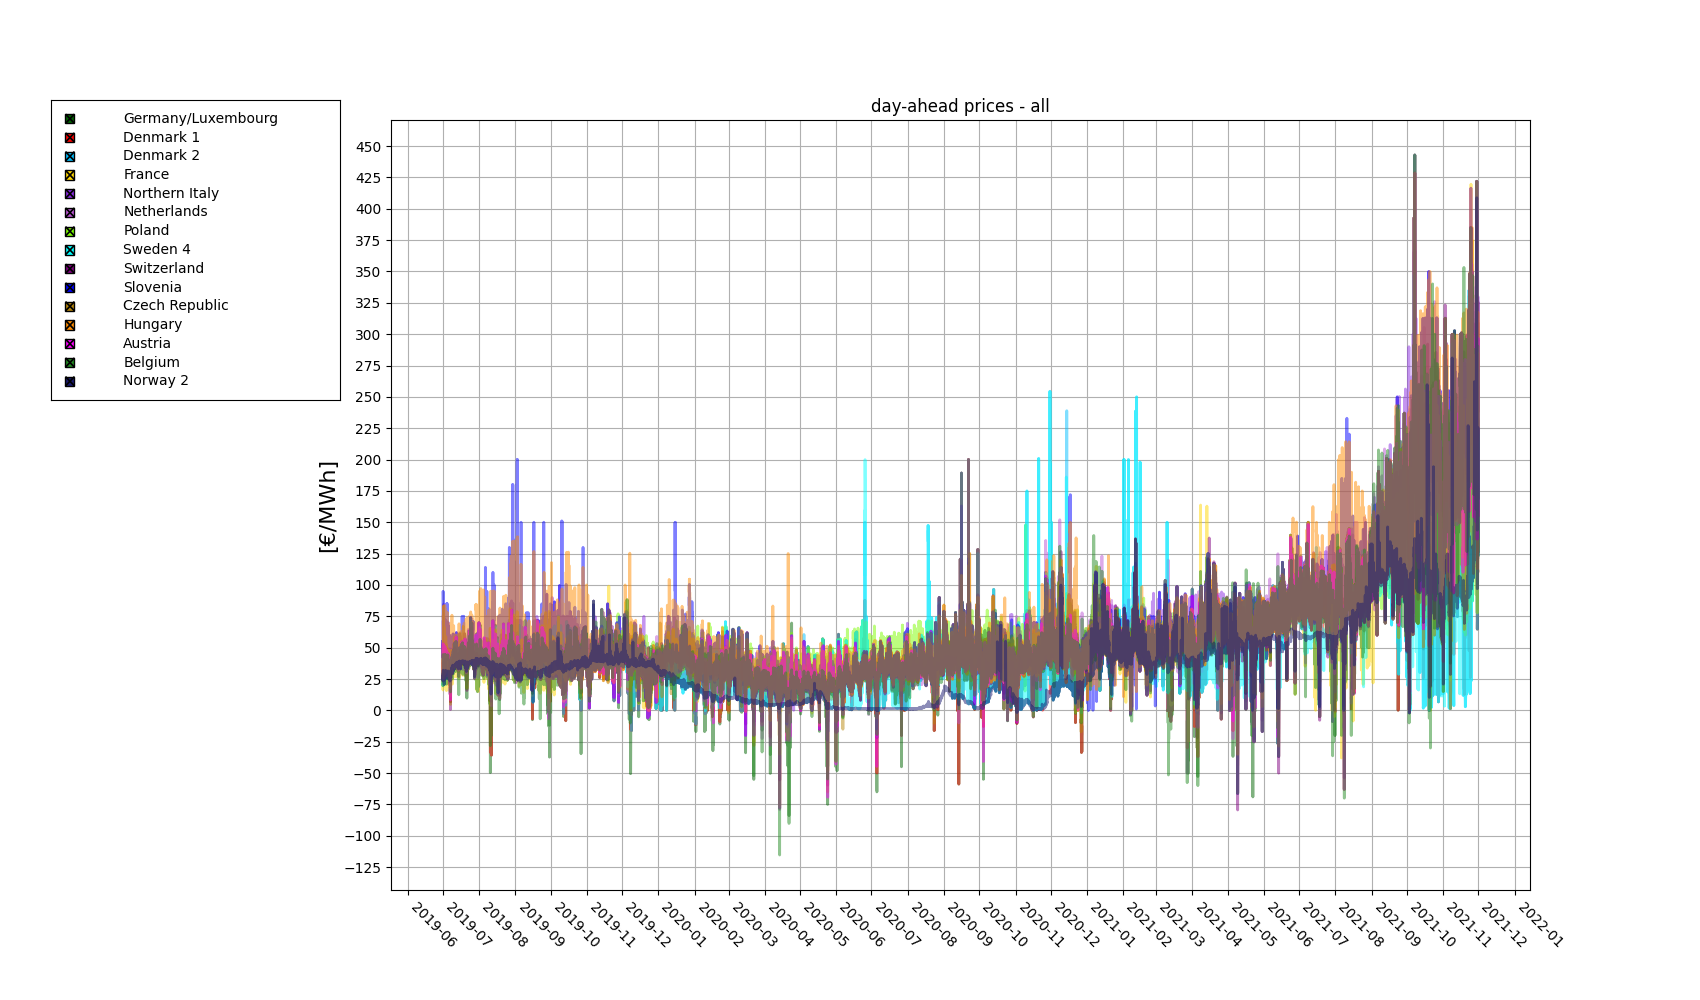

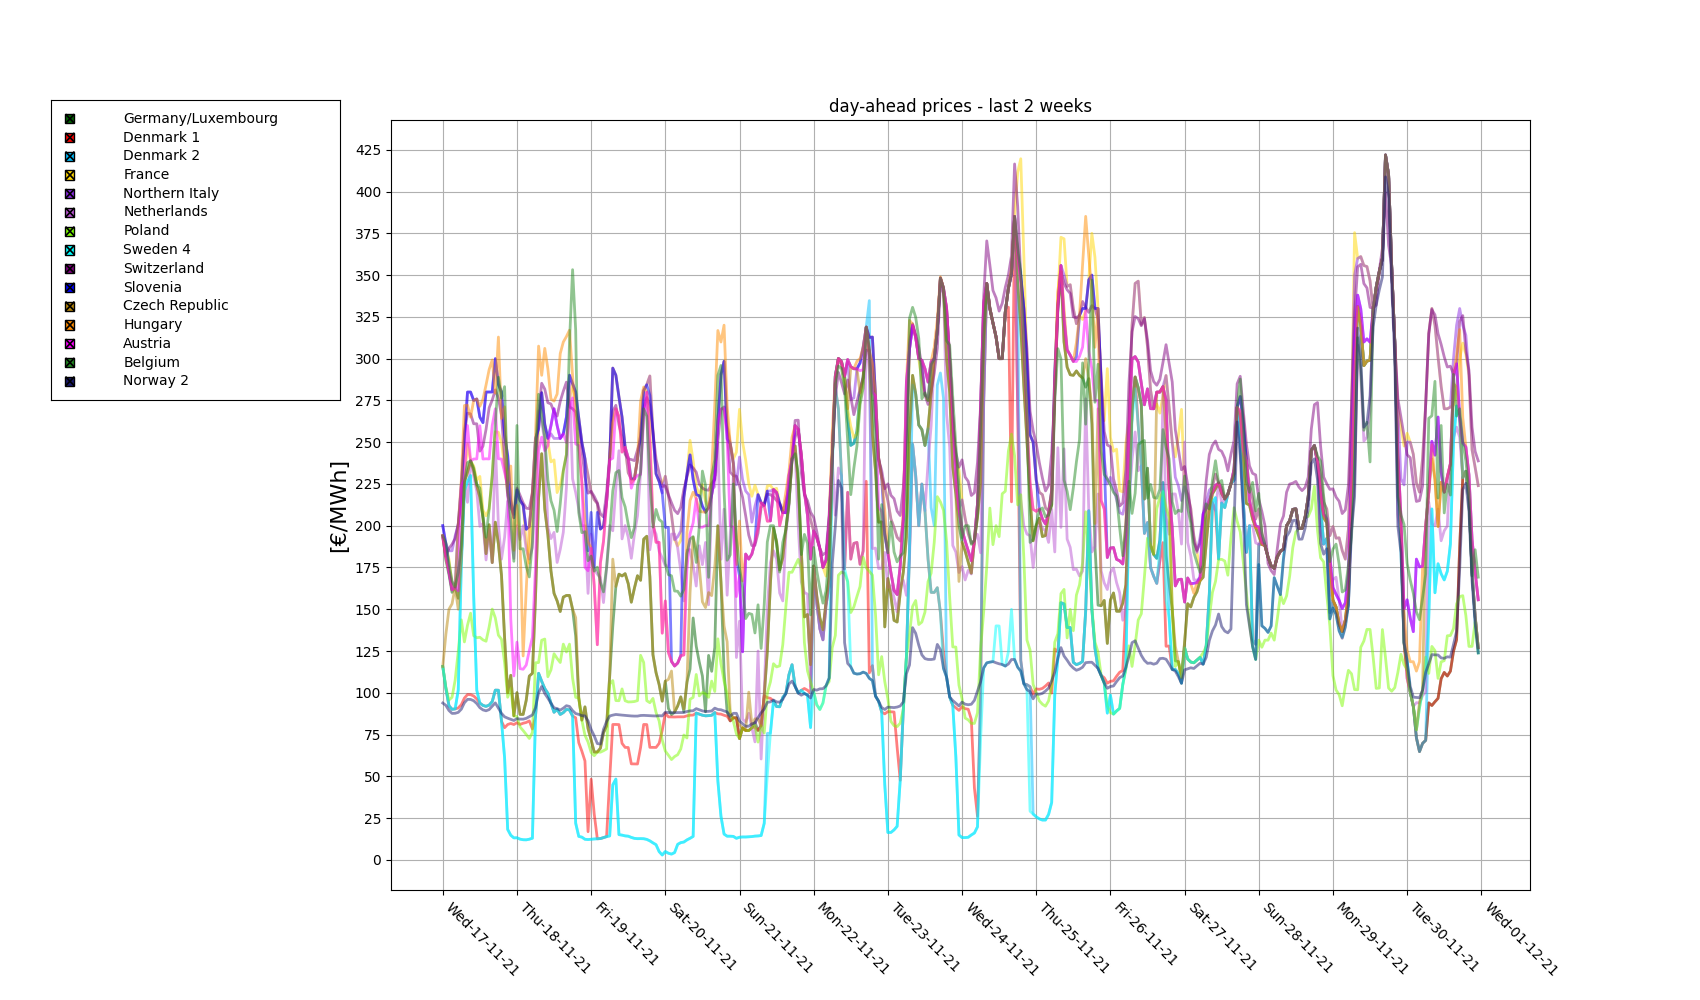

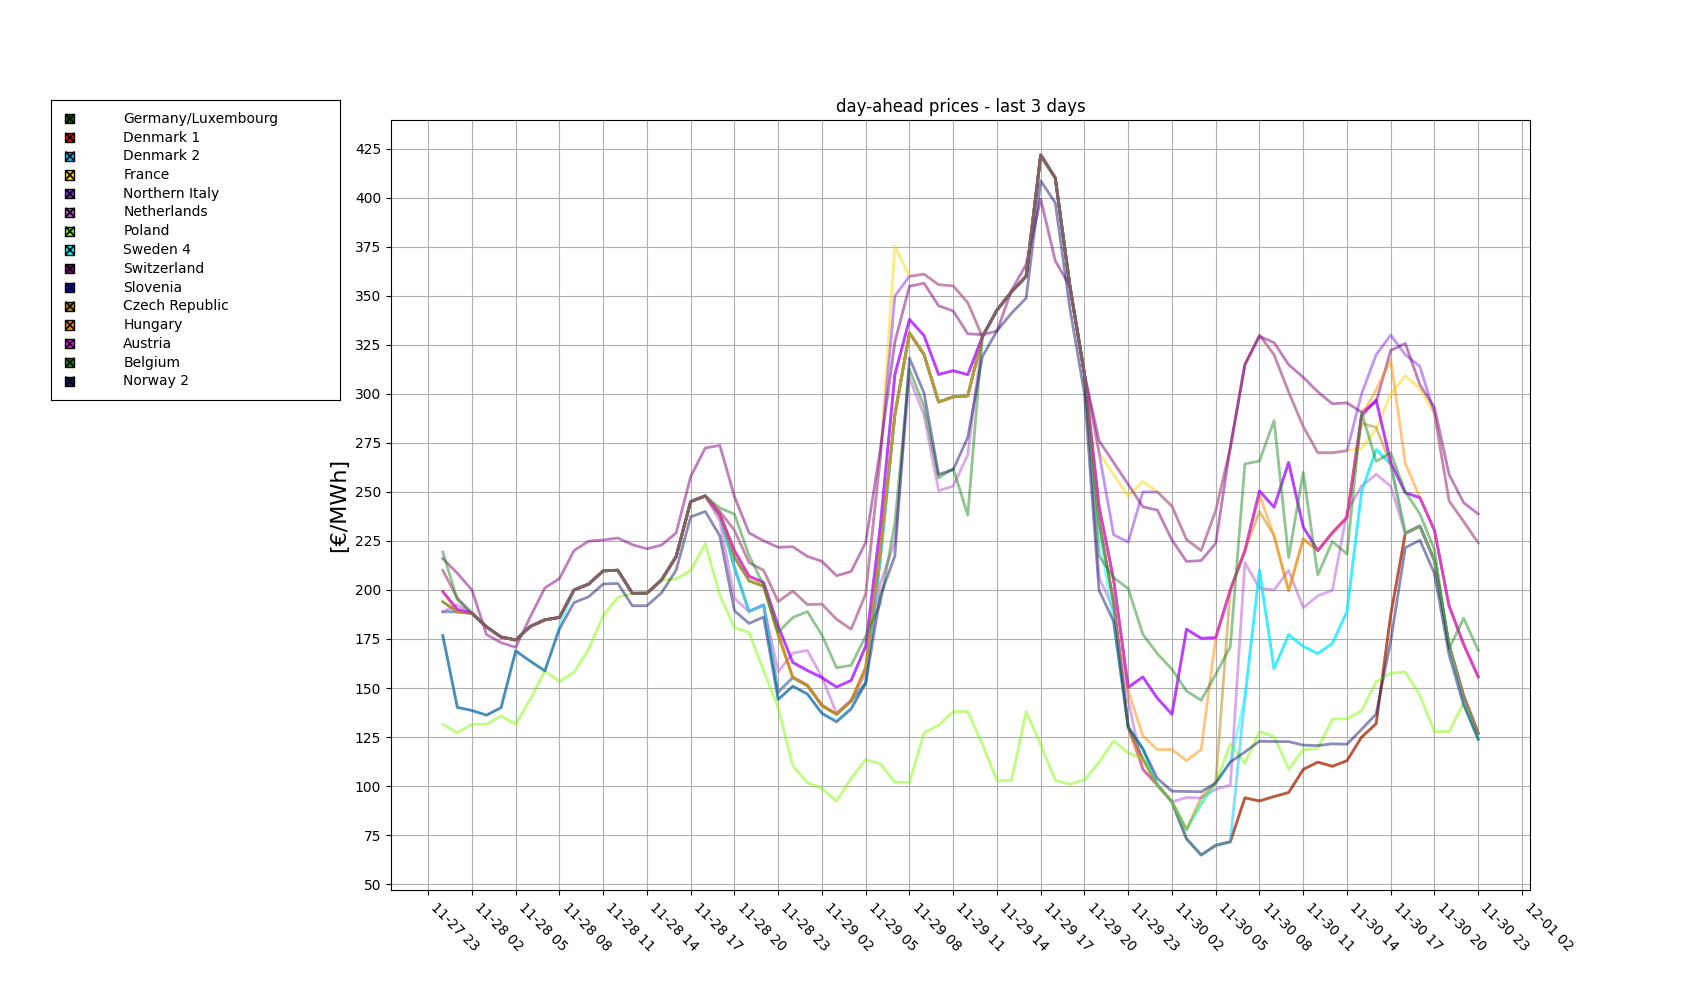

In [12]:
boxes_price_all = draw_line_graph(price_all, "day-ahead prices - all", ex_tick = 'month')
boxes_price_week_2 = draw_line_graph(price_week_2, "day-ahead prices - last 2 weeks", ex_tick = 'day')
boxes_price_days_3 = draw_line_graph(price_days_3, "day-ahead prices - last 3 days", ex_tick = 'hour')

#### GENERATION

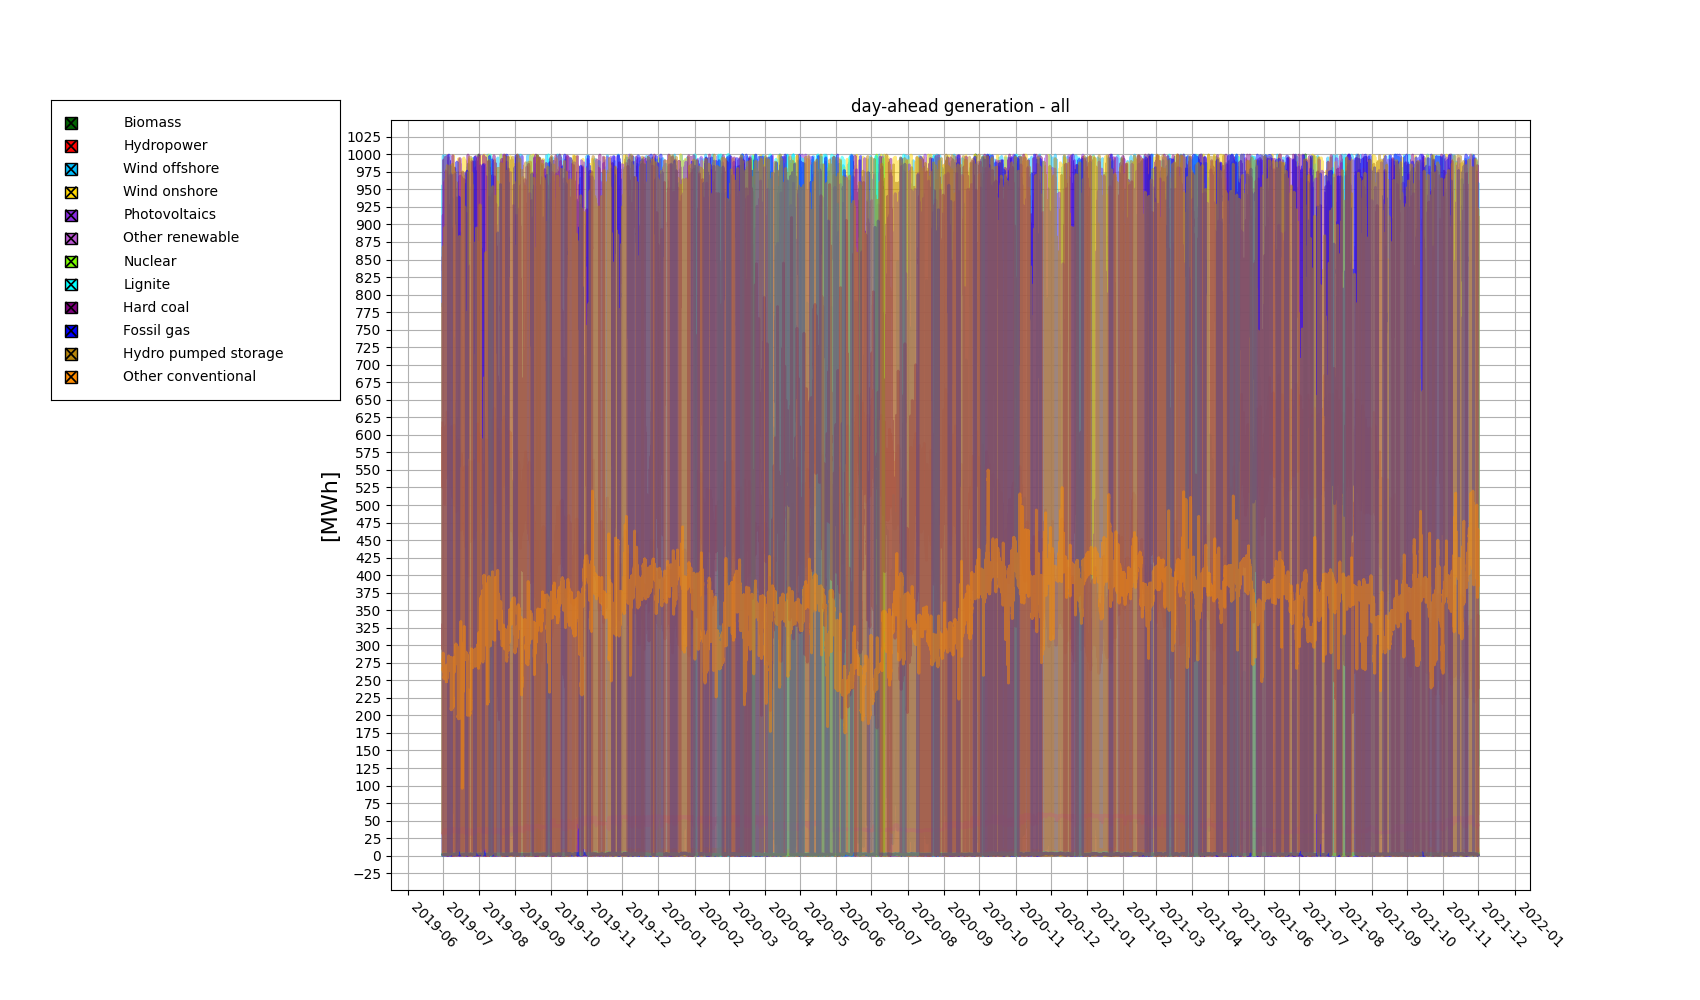

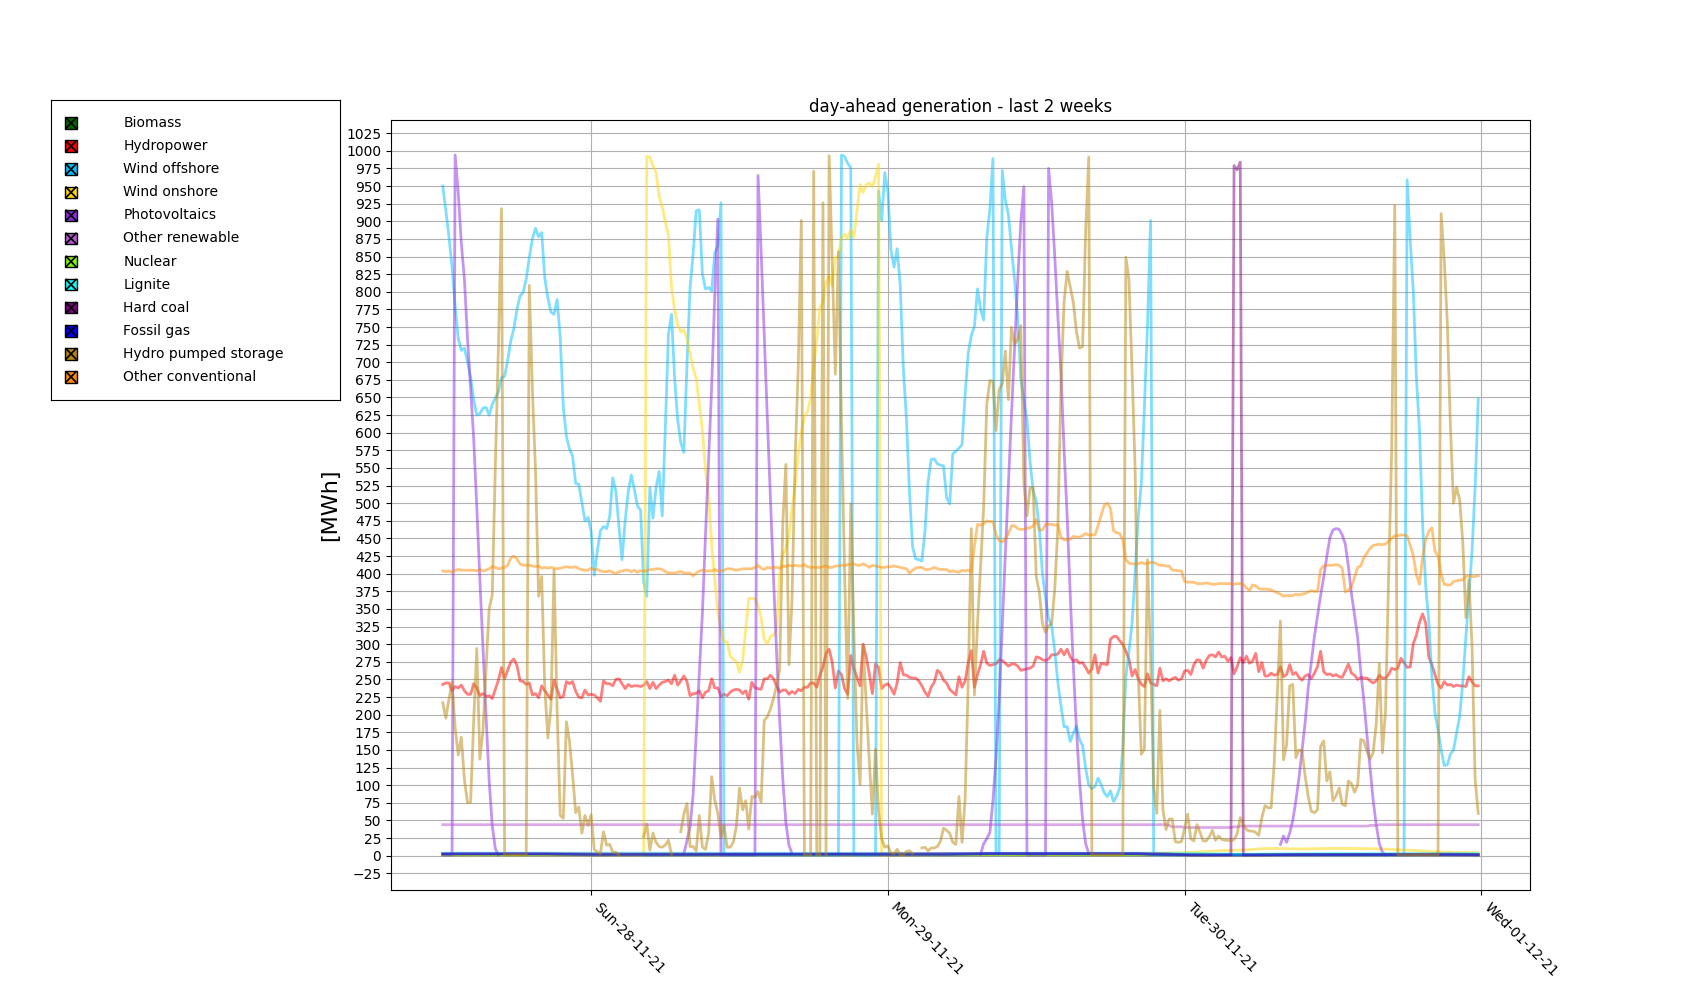

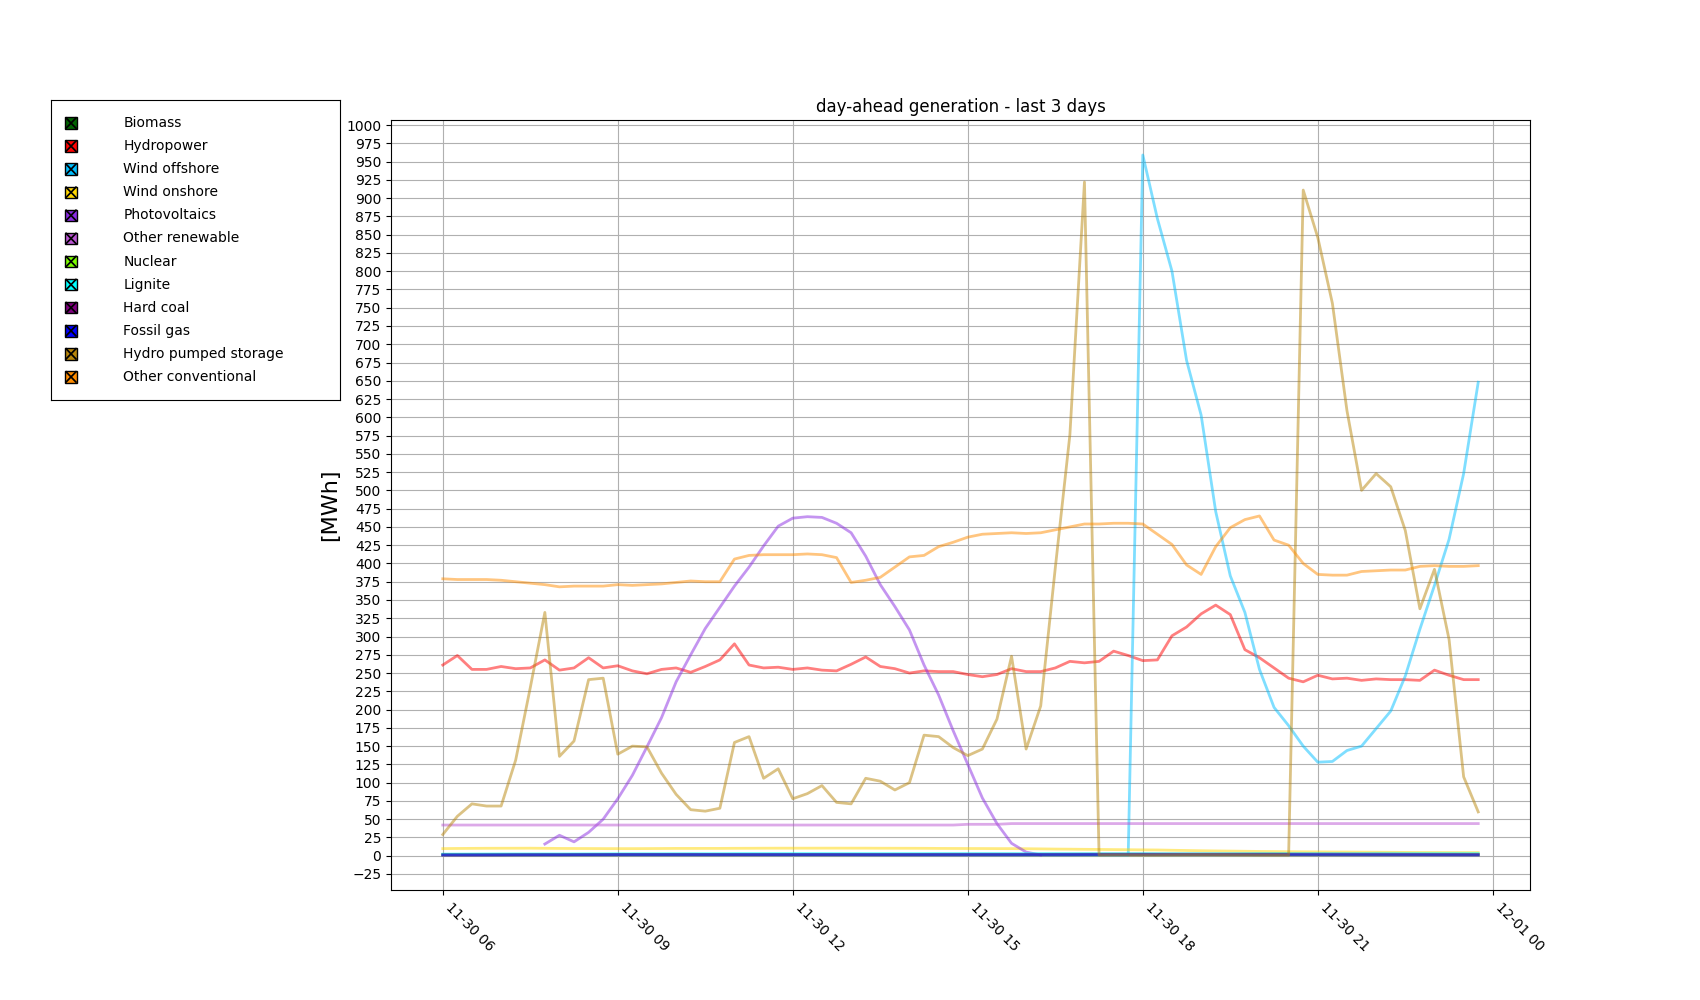

In [13]:
boxes_gener_all = draw_line_graph(gener_all, "day-ahead generation - all", ex_tick = 'month')
boxes_gener_week_2 = draw_line_graph(gener_week_2, "day-ahead generation - last 2 weeks", ex_tick = 'day')
boxes_gener_days_3 = draw_line_graph(gener_days_3, "day-ahead generation - last 3 days", ex_tick = 'hour')

#### CONSUMPTION

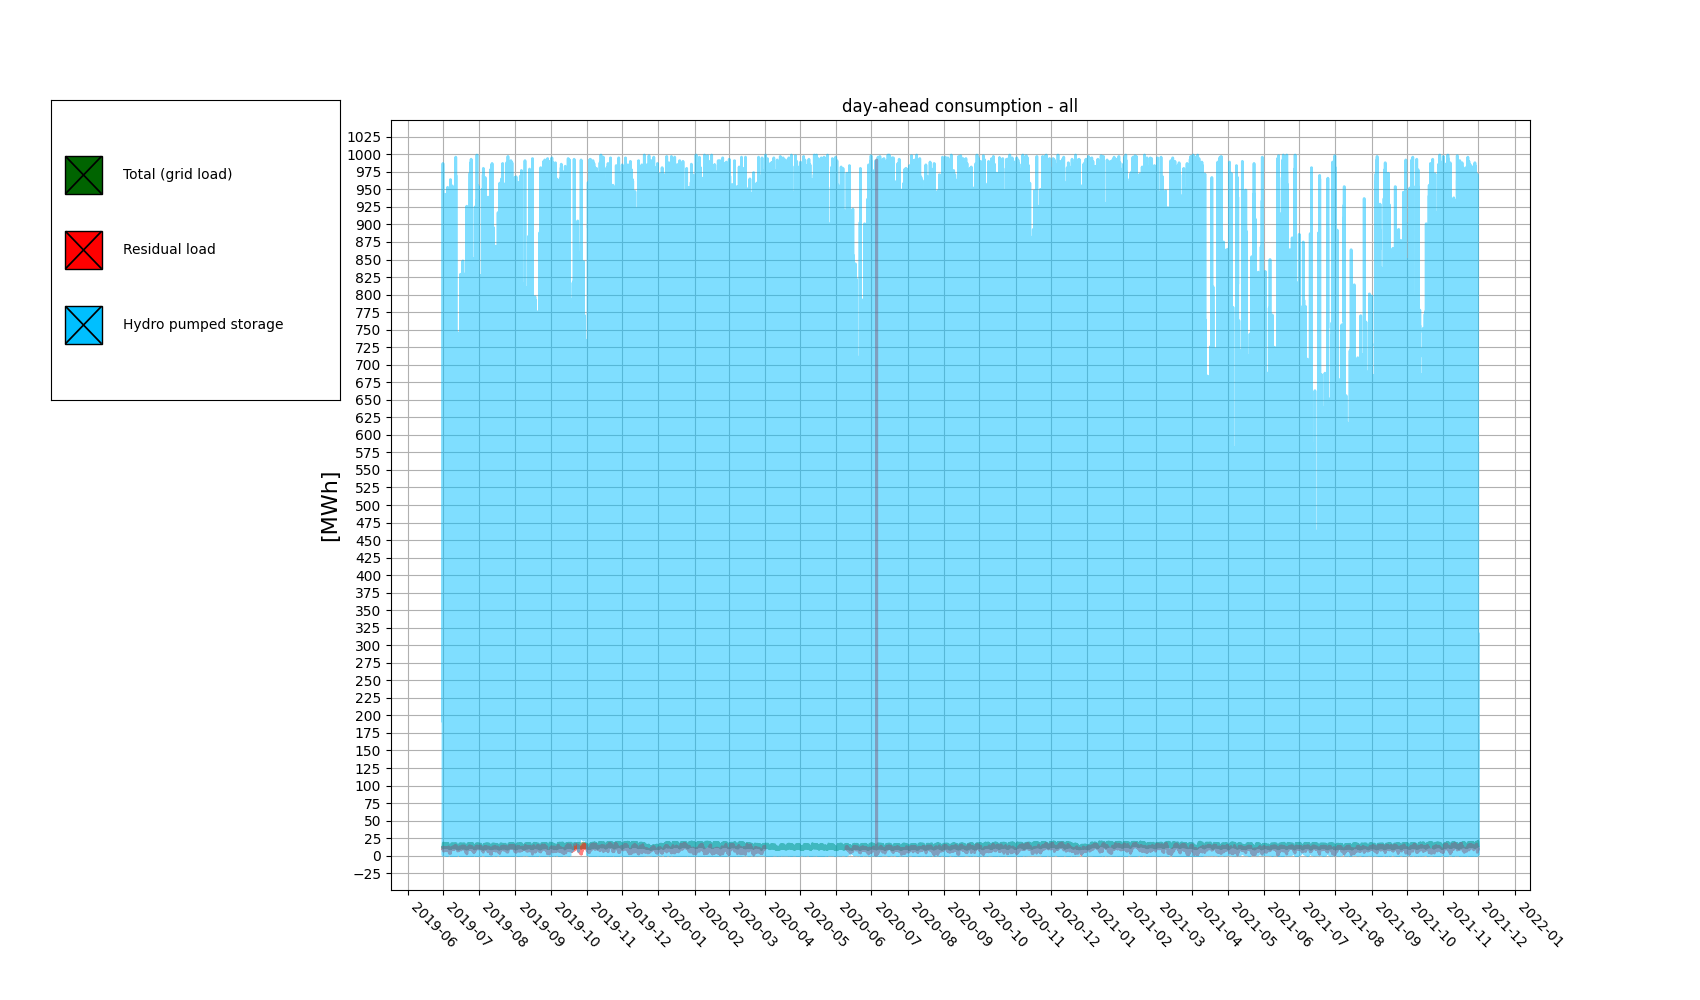

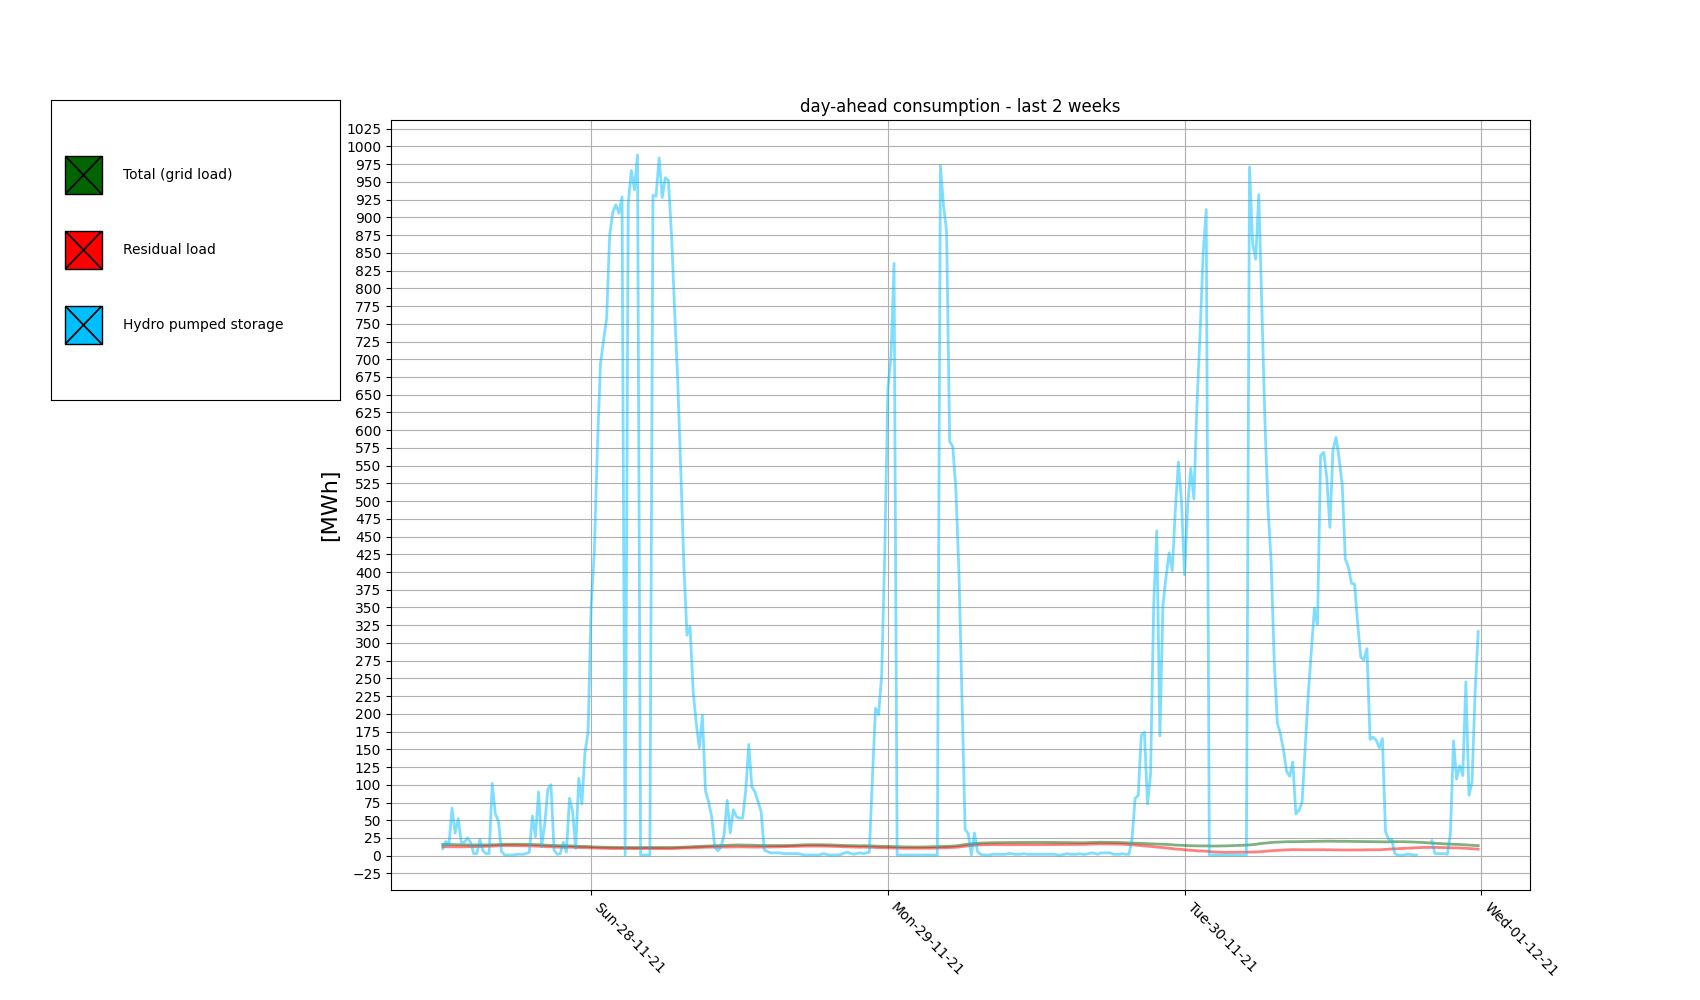

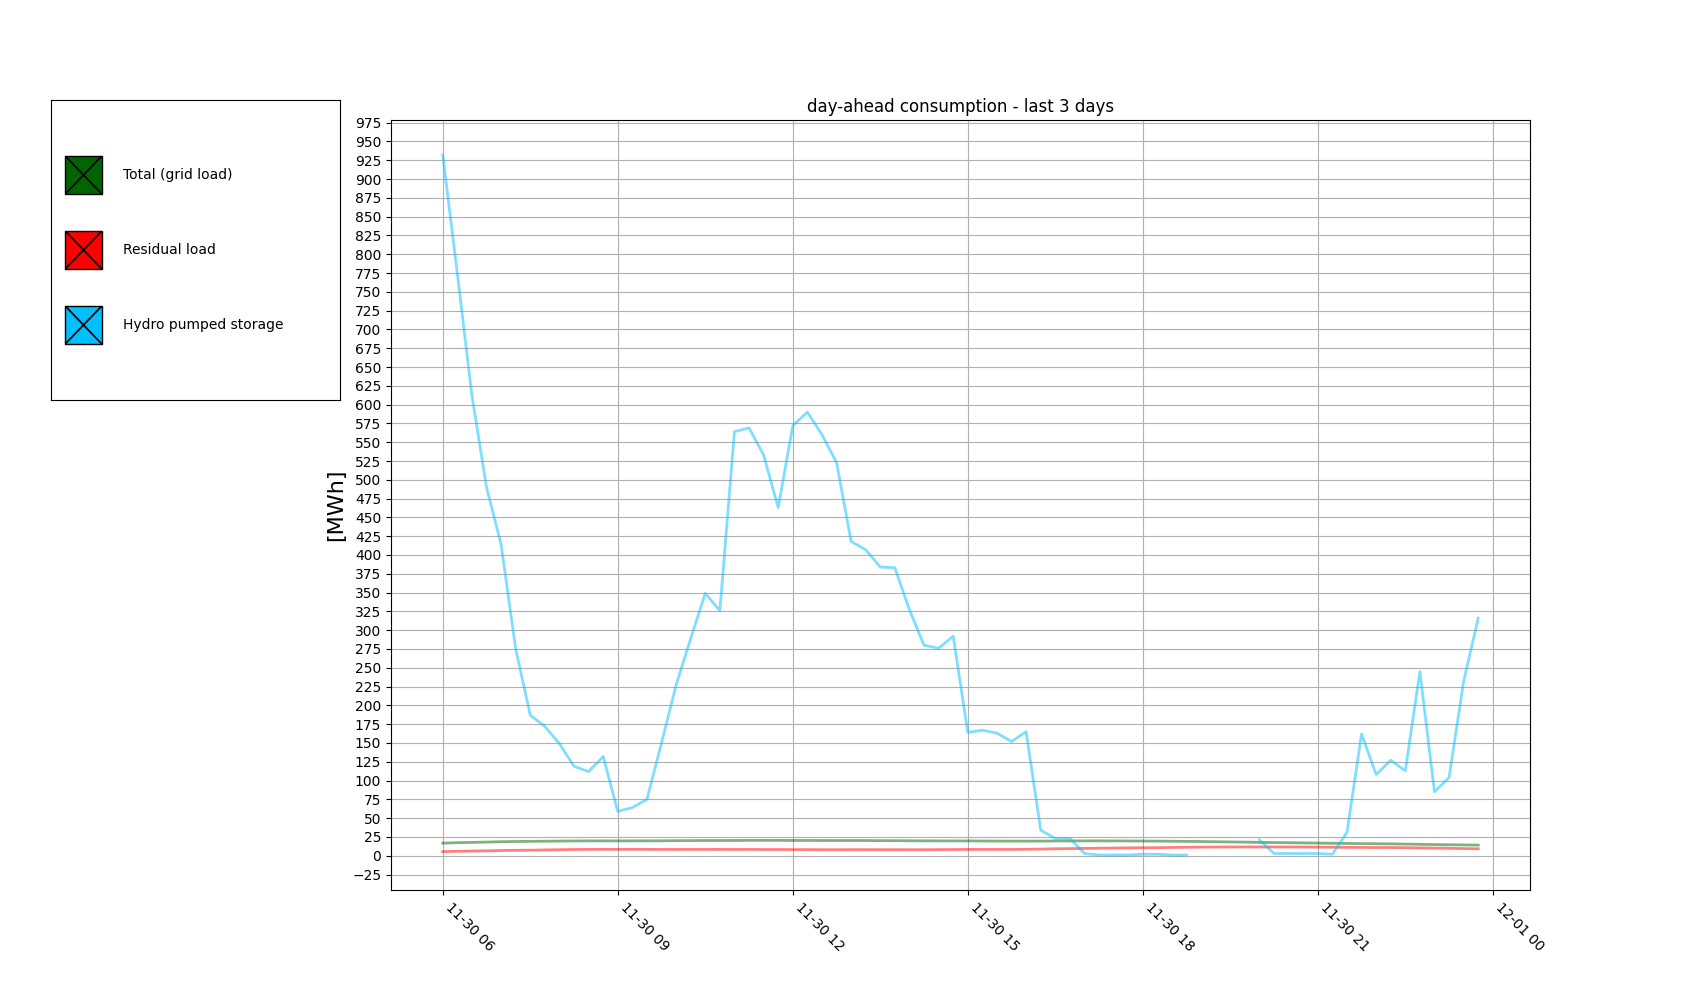

In [14]:
boxes_consu_all = draw_line_graph(consu_all, "day-ahead consumption - all", ex_tick = 'month')
boxes_consu_week_2 = draw_line_graph(consu_week_2, "day-ahead consumption - last 2 weeks", ex_tick = 'day')
boxes_consu_days_3 = draw_line_graph(consu_days_3, "day-ahead consumption - last 3 days", ex_tick = 'hour')

# CROSSCORELATION

#### 1-2-3 DAYS

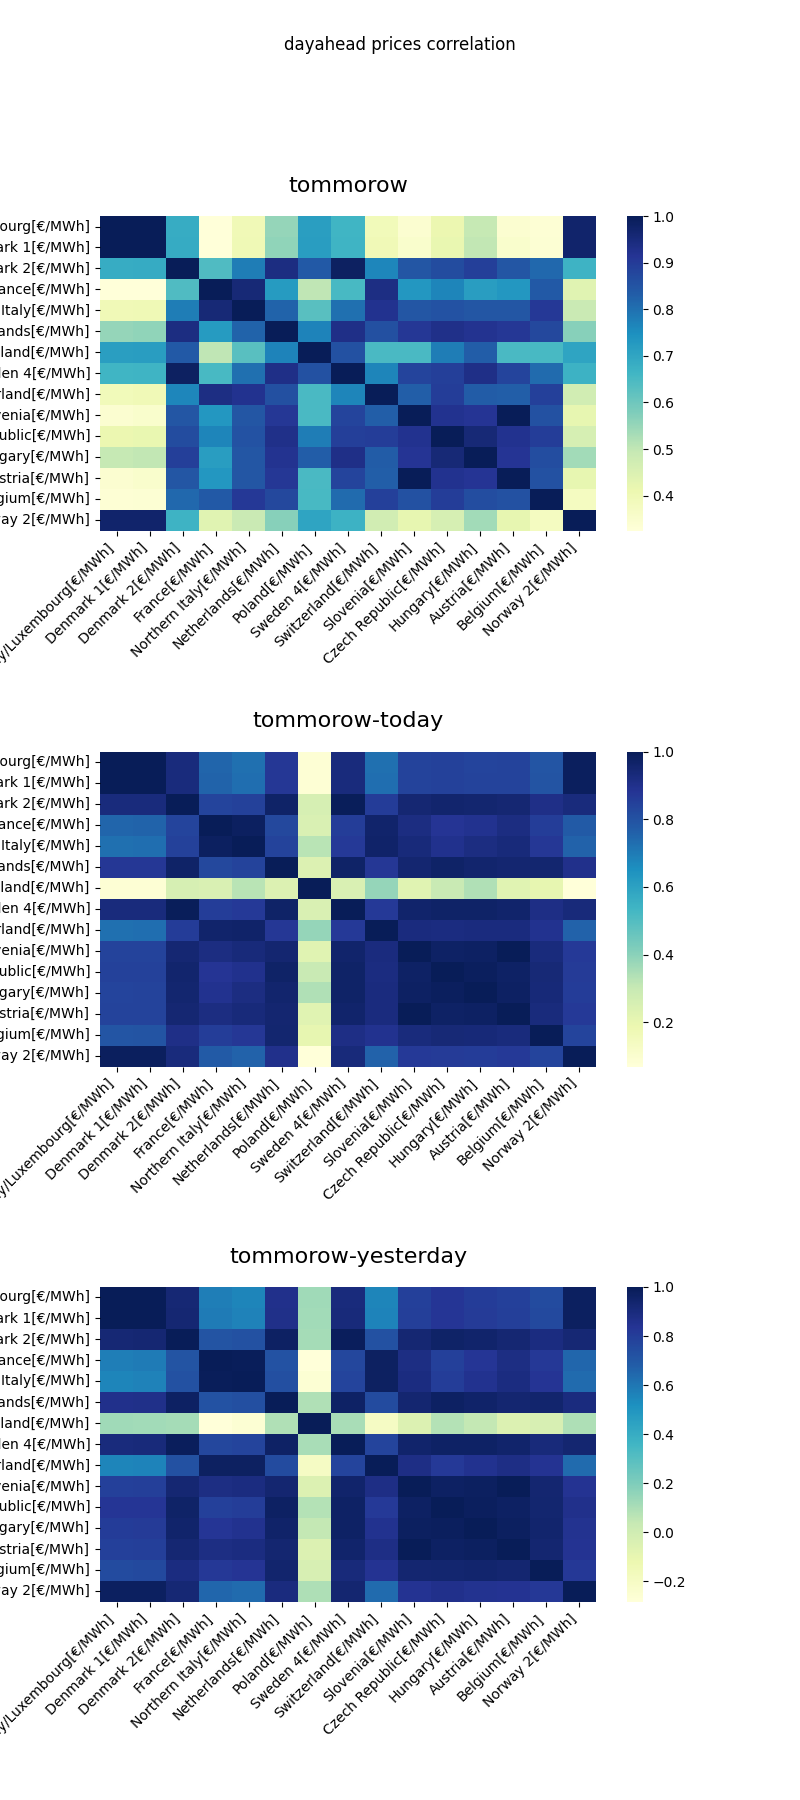

In [15]:
fig, axs = plt.subplots(3, figsize = (8,18));
fig      = plt.subplots_adjust(hspace = 0.7);
plt.suptitle('dayahead prices correlation')

axs[0].set_title('tommorow',           y = 1.05, size = 16)
axs[1].set_title('tommorow-today',     y = 1.05, size = 16)
axs[2].set_title('tommorow-yesterday', y = 1.05, size = 16)

corr = price_days_1.corr()
sns.heatmap(corr, cmap='YlGnBu', xticklabels=corr.columns, yticklabels=corr.columns, ax=axs[0]);
corr = price_days_2.corr()
sns.heatmap(corr, cmap='YlGnBu', xticklabels=corr.columns, yticklabels=corr.columns, ax=axs[1]);
corr = price_days_3.corr()
sns.heatmap(corr, cmap='YlGnBu', xticklabels=corr.columns, yticklabels=corr.columns, ax=axs[2]);

plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45, ha='right');
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45, ha='right');
plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45, ha='right');

#### POLAND DAY-AHEAD TO COUNTRIES 1-2-3 DAYS, DAY-TO-DAY

In [16]:
df_Poland_corr = df_corr_3days(price_all)
df_Poland_corr.corr().filter(['Poland tomorrow']).drop(['Poland tomorrow']).sort_values('Poland tomorrow', ascending = False)

Poland tomorrow
Sweden 4 tomorrow                    0.856914
Belgium today                        0.843484
Norway 2 yesterday                   0.842178
Denmark 2 tomorrow                   0.840780
Sweden 4 yesterday                   0.837657
Hungary tomorrow                     0.832449
Netherlands today                    0.829687
Norway 2 today                       0.810892
Poland yesterday                     0.809279
Hungary today                        0.805235
Switzerland yesterday                0.800672
Czech Republic today                 0.785542
Germany/Luxembourg today             0.785542
Denmark 2 today                      0.785143
Denmark 1 today                      0.785143
Sweden 4 today                       0.779557
Czech Republic tomorrow              0.778509
Slovenia today                       0.774342
Austria today                        0.774342
Switzerland today                    0.772419
Netherlands tomorrow                 0.768897
Austria yesterday                    0.768644
Slovenia yesterday                   0.768644
Czech Republic yesterday             0.764071
Germany/Luxembourg yesterday         0.764071
Northern Italy yesterday             0.760407
France yesterday                     0.760407
Hungary yesterday                    0.760223
France today                         0.746867
Northern Italy today                 0.729912
Denmark 1 tomorrow                   0.718522
Germany/Luxembourg tomorrow          0.717348
Norway 2 tomorrow                    0.704102
Belgium yesterday                    0.698176
Netherlands yesterday                0.686490
Denmark 2 yesterday                  0.664905
Denmark 1 yesterday                  0.664905
Belgium tomorrow                     0.654008
Slovenia tomorrow                    0.651282
Austria tomorrow                     0.651282
Switzerland tomorrow                 0.649084
Northern Italy tomorrow              0.627731
France tomorrow                      0.503151
Poland today                         0.292122

#### CROSSCORRELATION POLAND TO COUNTRIES WHOLE PERIOD

In [17]:
price_all.corr().filter(['Poland[€/MWh]']).drop(['Poland[€/MWh]']).sort_values(['Poland[€/MWh]'], ascending = False)

Poland[€/MWh]
Czech Republic[€/MWh]           0.913042
Germany/Luxembourg[€/MWh]       0.896779
Austria[€/MWh]                  0.885075
Netherlands[€/MWh]              0.869623
Hungary[€/MWh]                  0.867044
Denmark 1[€/MWh]                0.866071
Belgium[€/MWh]                  0.864287
Slovenia[€/MWh]                 0.862632
France[€/MWh]                   0.859875
Northern Italy[€/MWh]           0.857959
Denmark 2[€/MWh]                0.854794
Switzerland[€/MWh]              0.852054
Sweden 4[€/MWh]                 0.832913
Norway 2[€/MWh]                 0.794988

# REGRESSION

In [260]:
def generate_dfs_train_test(price_df,gener_df,consu_df, columns  = ['Date','Poland[€/MWh]','Czech Republic[€/MWh]','Germany/Luxembourg[€/MWh]','Austria[€/MWh]','Netherlands[€/MWh]','Hungary[€/MWh]'], ratio = 0.2):

    df = price_df[columns].copy()
    df['gener. total[MWh]'] = gener_df.sum(axis=1, numeric_only =True)
    df = df.join(consu_df['Total (grid load)[MWh]'])
    df = df.rename(columns={'Total (grid load)[MWh]':'consu. Total (grid load)[MWh]'})
    
    #dropna
    #df = df[df[columns[1]].notna()]
    df = df.dropna()
    df.reset_index(inplace = True, drop = True)
    
    #df[columns[0]] = pd.Series([val.time() for val in df[columns[0]]])
    df[columns[0]] = df[columns[0]].dt.hour.astype(np.float64)
    
    x_train, x_test = train_test_split(df[columns[1]], test_size = ratio, shuffle=False)
    
    x_train = x_train.values.reshape(-1,1)
    x_test = x_test.values.reshape(-1,1)
    
    df = df.drop(columns = columns[1])
    y_train, y_test = train_test_split(df, test_size = ratio, shuffle=False)

    return x_train, x_test, y_train, y_test;

In [265]:
x_train, x_test, y_train, y_test = generate_dfs_train_test(price_all,gener_all,consu_all)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
print(lr_model.score(x_test, y_test))

0.0014121820151341696


In [263]:
y_pred = lr_model.predict(x_test)
plt.scatter(x_test, y_test, color ='b')
plt.plot(x_test, y_pred, color ='k')

ValueError: x and y must be the same size